# Acronym resolution (`acres`) demo

This is a demo of the `acres` project.

## Configuration

### Working directory

All `acres` code should run under the root folder.

In [25]:
import os
cwd = os.getcwd()
if "notebooks" not in os.listdir(cwd):
    #os.chdir("..")
    print("Wrong working directory: " + cwd)
    
os.getcwd()

'/Users/michel/git/acres'

### Clear output

Let's disable gensim warnings (this seems to be a problem with gensim 3.6.0 only).

In [26]:
import warnings
warnings.filterwarnings('ignore')

Let's also disable `matplotlib` debug messages.

In [27]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

## Using word2vec

We trained a word2vec model using [gensim](https://radimrehurek.com/gensim/models/word2vec.html) on a cardiology corpus written in German. We obtained best results with a continuous bag-of-words (CBOW) model with a window size of 2.

### 2D representation

We can use PCA to visualize the vector space.

In [28]:
from acres.preprocess import resource_factory

model = resource_factory.get_nn_model()

words = ["gutem", "gebessertem",
         "CMP", "Cardiomyopathie", "Kardiomyopathie", "Kardiomoypathie",
         #"SR", "Sinusrhythmus",
         "HF", "Herzfrequenz",
         #"GGT", "y_GT",
         "RR", "Blutdruck",
         "EF", "Auswurffraktion",
         "AP", "Angina_pectoris"]

# or 50 random words...
#words = list(model.wv.vocab)[0:50]

X = model[words]

In [29]:
from matplotlib import pyplot

def display_words(data, words):
    f = pyplot.figure()
    pyplot.scatter(data[:, 0], data[:, 1])

    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(data[i, 0], data[i, 1]))
    pyplot.show()
    
    f.savefig("plot.pdf", bbox_inches="tight")

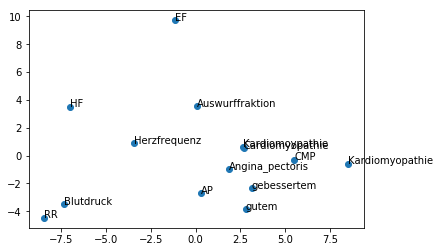

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = pca.fit_transform(X)
display_words(data, words)

If we're feeling fancier, we can also try tSNE:

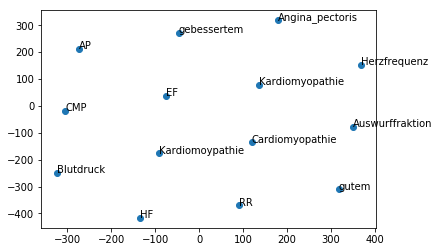

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
data = tsne.fit_transform(X)
display_words(data, words)

### Raw results from word2vec

In [32]:
from acres.nn import test

def word2vec_raw(acronym):
    return test.find_candidates(acronym)

The model allows us to get words that occur in a similar context.

In [33]:
word2vec_raw("gutem")

['zufriedenstellendem',
 'gebessertem',
 'reduziertem',
 'verbessertem',
 'altersentsprechendem',
 'schlechtem',
 'gebesserten',
 'guten',
 'häusl',
 'deutl gebessertem']

It can also be used for spell checking, as typos happen in similar contexts than the correct spelling.

In [34]:
word2vec_raw("Cardiomyopathie")

['Kardiomoypathie',
 'Kardioymopathie',
 'Kardiomyopatie',
 'Kardiomypathie',
 'Kardiomyopathie',
 'Kardiopmyopathie',
 'CMP',
 'Operierte KHKIII',
 'Verlaufsform',
 'Komponente']

It turns out that acronym expansions also happen in similar contexts than the acronym itself:

In [35]:
word2vec_raw("SR")

['min',
 'Sinusrhythmus',
 'Sr',
 'HF',
 'Normocarde VHFA',
 'Atriale Stimulation',
 'Sinusbradykardie',
 'h',
 'Frequenz',
 'VHF']

In [36]:
word2vec_raw("HF")

['Herzfrequenz',
 'Frequenz',
 'Solllast',
 'Ausbelastung',
 'Puls',
 'Hf',
 'min',
 'Min',
 'Watt',
 'Schlägen']

In [37]:
word2vec_raw("GGT")

['GT',
 'y GT',
 'LDH',
 'ALT',
 'Myoglobin',
 'MBq Xe',
 'Trigl',
 'Bili',
 'U l',
 'Ferritin']

As this is a semantic model, note that it also works for non-trivial expansions, like `RR => Blutdruck`.

In [38]:
word2vec_raw("RR")

['Blutdruck',
 'Gas',
 'Xe',
 'Certralin',
 'MBq Xe',
 'BZ',
 'ÐÐÐmmHg',
 'PZ INR',
 'Gas Ventilationsszintigraphie',
 'Tageswert']

(RR is a common acronym for designating "blood pressure" in German. It stems from the inventors of the cuff-based sphygmomanometer, the italians Riva and Rocci 🙂)


It also works for terms borrowed from other languages (e.g. English), such as `EF => Auswurffraktion` (ejection fraction).

In [39]:
word2vec_raw("EF")

['LVEF',
 'Auswurffraktion',
 'Simpson',
 'diastolische',
 'diast',
 'linksventrikulären volumetrischen',
 'diastol',
 'Farbdopplerechokardiographie',
 'EDP',
 'LVEDD']

We also enriched the model with common collocations provided by the `Phraser` module so that it also works for multiwords acronyms:

In [40]:
word2vec_raw("AP")

['Ap',
 'pectanginöse',
 'Atemnot',
 'Dyspnoe',
 'pectanginösen',
 'Angina pectoris',
 'Angina Pectoris',
 'Schwindel',
 'Schwindelsymptomatik',
 'Angina']

It does not work, however, for acronyms that are never expanded in the collection:

In [41]:
word2vec_raw("EKG")

['Schrittmacheraktivität',
 'Durchgehend',
 'USKG',
 'Holter',
 'flachen',
 'permanenter',
 'Langzeit',
 'Std',
 'Schädel CT',
 'Spiroergometrie']

### Filtered results

For proper acronym expansion, we further filter results using hand-crafted rules.

In [42]:
from acres.evaluation import evaluation

def word2vec_filtered(acronym):
    return evaluation.cached_resolve(acronym, "", "", evaluation.Strategy.WORD2VEC)

In [43]:
word2vec_filtered("SR")

['Sinusrhythmus', 'Sinusbradykardie']

In [44]:
word2vec_filtered("HF")

['Herzfrequenz']

In [45]:
word2vec_filtered("AP")

['Angina pectoris', 'Angina Pectoris']

Unfortunately, the current rules are too restrictive and do not allow semantic expansions...

In [46]:
word2vec_filtered("RR")

[]

In [47]:
word2vec_filtered("EF")

[]